<a href="https://colab.research.google.com/github/hydrationn/Machine-DeepLearning/blob/main/DeepLearning/assignment/%EA%B3%BC%EC%A0%9C4_1_202101109_%EB%B0%95%EC%88%98%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic CNN Model

In [2]:
# import package

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
# GPU/CPU setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

cuda


In [4]:
# import dataset

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform = transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform = transforms.ToTensor(), download=True)

100%|██████████| 170498071/170498071 [00:06<00:00, 28316785.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Batch generation

batch_size = 100

train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([100])
torch.Size([100, 3, 32, 32])
torch.Size([3, 32, 32])
tensor(9)


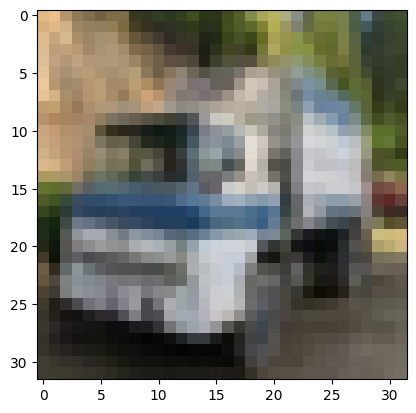

In [6]:
# Batch generation

for i, data in enumerate(train_loader):
  x,y = data
  print(y.shape)
  print(x.shape)
  print(x[0].shape)
  print(y[0])
  plt.imshow(x[0].permute(1, 2, 0))
  break

In [7]:
# Practice. CIFAR10 image classificaiton
# Convolutional layers

conv1 = nn.Conv2d(3, 64, kernel_size = 1, stride = 1, padding = 1)
conv2 = nn.Conv2d(64, 128, kernel_size = 5, stride = 2, padding = 0)
print(conv1)
print(conv2)

Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))


In [8]:
input_data = torch.Tensor(1, 3, 32, 32)
print(input_data.shape)

torch.Size([1, 3, 32, 32])


In [9]:
print(conv1(input_data).shape)

torch.Size([1, 64, 34, 34])


In [10]:
pool = nn.MaxPool2d(2)
print(pool(conv1(input_data)).shape)

torch.Size([1, 64, 17, 17])


In [11]:
final_output = conv2(pool(conv1(input_data)))
print(final_output.shape)

torch.Size([1, 128, 7, 7])


In [14]:
final_output = pool(final_output)
print(final_output.shape)

torch.Size([1, 128, 3, 3])


In [15]:
out = final_output.view(final_output.shape[0], -1)
print(out.shape)

torch.Size([1, 1152])


In [16]:
fc = nn.Linear(1152, 10)
fc(out).shape

torch.Size([1, 10])

In [20]:
# Practice. CIFAR10 image classification

# Model
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [21]:
# Model

model = MyCNN().to(device)
model

MyCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): L

In [22]:
# Parameter, model, loss function, optimizer

# Hyperparameters
num_epochs = 10
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [23]:
# Train

loss_list = []

for epoch_num in range(num_epochs):
  average_cost = 0

  for batch_idx, (x_data, y_label) in enumerate(train_loader):
    num_of_mini_batch = len(train_loader)
    x_data = x_data.to(device)
    input_image = x_data.reshape(batch_size, 3, 32 ,32)
    label = y_label.to(device)

    optimizer.zero_grad()

    y_predict = model(input_image)
    loss = criterion(y_predict, label)

    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 2.06950
Epoch 2 Loss 1.49534
Epoch 3 Loss 1.23062
Epoch 4 Loss 1.08777
Epoch 5 Loss 1.00039
Epoch 6 Loss 0.94127
Epoch 7 Loss 0.89828
Epoch 8 Loss 0.85281
Epoch 9 Loss 0.80538
Epoch 10 Loss 0.77844


In [24]:
# Validation

with torch.no_grad():
  num_total_data = 0
  correct = 0
  for batch_idx, (images, labels) in enumerate(test_loader):

    images = images.reshape(batch_size, 3, 32, 32)

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    outputs_softmax = F.softmax(outputs, dim=1)

    predicted = torch.argmax(outputs_softmax, dim=1)

    num_total_data += len(images)

    answer = sum(labels==predicted).item()
    correct += answer

print("Model accuracy {:5f}%".format((correct/num_total_data)*100))

Model accuracy 67.720000%
